* Import predictions for Rephetio, CBR Methods and KGE Methods
* Create a pipeline to get overlap information for each pair
* Generate a heatmap for the 42 pairwise comparisons

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import score_utils
import statistics
import re
import itertools
import pickle
from collections import defaultdict as dd

## Import probCBR results

In [2]:
def json_to_df(json_dir: str) -> pd.DataFrame:
    """
    Takes a string to a json object and turns it into a dataframe
    """
    # import the json object
    with open(json_dir, "r") as f:
        json_obj = json.load(f)

    # creates a dict with json keys as keys and values of emptylist based on the first json entry
    json_key_dict = {i: [] for i in list(json_obj[0].keys())}
    for i in json_obj:
        for j in json_key_dict.keys():
            # add j key in json item i to the list
            to_add = json_key_dict[j]
            to_add.append(i[j])
            json_key_dict.update({j: to_add})

    return pd.DataFrame(json_key_dict)

In [3]:
# dir to probCBR prediction results
df = json_to_df("/home/msinha/Open-BIo-Link/data.json")

### Import graph to filter prediction results

In [4]:
def process_dataframe(
    df: pd.DataFrame,
    data_dir: str,
    model_dir: str,
    mode: str = "tail-batch",
    rel=[
        "indication",
        "indication_CiD",
    ],
):
    """
    Gets True tail triples
    """

    # get true head/tail triples from graph
    raw = score_utils.ProcessOutput(
        data_dir=data_dir,
        scores_outfile=os.path.join(model_dir, "test_scores.tsv"),
        mode=mode,
    )
    graph = raw.get_true_targets()
    graph = graph.query("r in @rel")

    if mode == "tail-batch":
        # get true tail triples from graph

        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "h"}
            ),
            right=graph,
            how="left",
            on=["h", "r"],
        )
        merged = merged.rename(columns={"t": "true_t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_t"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_t)
        ]

    elif mode == "head-batch":
        # get True head triples from graph
        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "t"}
            ),
            right=graph,
            how="left",
            on=["r", "t"],
        )
        merged = merged.rename(columns={"t": "true_h", "h": "t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_h"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_h)
        ]

    else:
        raise ValueError(f'{batch} is not in {"head-batch","tail-batch"}')
    return merged


def filter_predictions(df: pd.DataFrame, top: int = 50) -> pd.DataFrame:
    """
    Get filtered predictions that don't exist as triples in Train/Test/Valid

    Inputs
    -----------
    - df        * dataframe to translate embeddings
    - top       * get the top 'n' results for each prediction.
                * `top = -1` if you want all results
    """
    # remove answer from predicted_answers
    df["filt_preds"] = df.apply(
        lambda i: score_utils.ProcessOutput.remove_list_from_list(
            i["predicted_answers"], i["answers"]
        ),
        axis=1,
    )
    df = df.rename(columns={"t": "true_t"}).drop(columns="predicted_answers")

    # get the top number of predictions
    df["filt_preds"] = df["filt_preds"].apply(lambda x: x[0:top])

    return df

Original
```python
def get_known_triples(
    graph_dir: str, batch: str = "tail", rel=["indication", "treats"]
) -> pd.DataFrame:
    """
    Gets a dataframe of known triple results given a graph file.
    * graph_dir      file path of the entire graph
    * batch          {"head" | "tail"}
                     where "head" corresponds to getting all "head" results w/ respect to relation and tail
                     and "tail" corresponds to getting all "tail" results w/ respect to head and relation
    * rel            Optional, filter for results on a specific relation.
    """
    # import the graph file
    graph = pd.read_csv(graph_dir, sep="\t", names=["h", "r", "t"])

    # process the relation
    graph["r_split"] = graph.r.apply(lambda x: re.findall("^[^A-Z]+", x)[0])
    graph["r_split"] = graph.r.apply(lambda x: x[0:-1] if x[-1] == "_" else x)

    # If rel is true, filter for them.
    if rel != None and rel == str:
        graph = graph.query("r==@rel")
    elif rel != None and rel == list:
        graph = graph.query("r in @rel")

    # Batch filter (specify the direction)
    if batch == "head":
        graph = graph[["h", "t"]].groupby("t").agg(lambda x: list(x)).reset_index()
    elif batch == "tail":
        graph = graph[["h", "t"]].groupby("h").agg(lambda x: list(x)).reset_index()
    else:
        raise ValueError(f"Argument {batch} is not in {'head', 'tail'}")

    return graph


def process_dataframe(
    df: pd.DataFrame, graph_dir: str, batch: str = "tail", rel=["indication", "treats"]
):
    """
    Gets True tail triples
    """

    if batch == "tail":
        # get true tail triples from graph
        graph = get_known_triples(
            graph_dir=graph_dir,
        )
        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "h"}
            ),
            right=graph,
            how="left",
            on="h",
        )
        merged = merged.rename(columns={"t": "true_t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_t"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_t)
        ]

    elif batch == "head":
        # get True head triples from graph
        graph = get_known_triples(
            graph_dir=graph_dir, batch="head", rel=["indication", "treats"]
        )
        merged = pd.merge(
            left=df[["e1", "r", "answers", "predicted_answers"]].rename(
                columns={"e1": "h"}
            ),
            right=graph,
            how="left",
            on="h",
        )
        merged = merged.rename(columns={"t": "true_h", "h": "t"})

        # ensure answers is in 'true_t'. First remove all predicted answers with no predictions
        merged = merged[merged["predicted_answers"].apply(lambda x: len(x) > 0)]
        # add answers to true t
        merged["true_h"] = [
            list(set(val) | set(merged.answers.iloc[ind]))
            if type(val) != float
            else list(set(merged.answers.iloc[ind]))
            for ind, val in enumerate(merged.true_h)
        ]

    else:
        raise ValueError(f'{batch} is not in {"head","tail"}')
    return merged
```

In [5]:
df.head(2)

,e1,r,answers,predicted_answers
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:6000, DOID:10763, DOID:10591,..."
1,DOID:10763,indication_inv,"[CHEBI:135735, CHEBI:135738, CHEBI:141521, CHE...","[CHEBI:31548, CHEBI:46632, CHEBI:5784, CHEBI:5..."


In [7]:
df = df.query('r=="indication"')
df.shape

(386, 4)

In [8]:
# drops probCBR without predictions
merged = process_dataframe(
    df=df,
    data_dir="../data/MIND_CtD/",
    model_dir="../models/TransE_MIND_CtD_megha/",
)

In [9]:
merged.head(2)

,h,r,answers,predicted_answers,true_t
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:6000, DOID:10763, DOID:10591,...","[DOID:6432, DOID:10825, DOID:10763, DOID:10591..."
1,CHEBI:135738,indication,[DOID:10763],"[DOID:10763, DOID:446, DOID:10591, DOID:10824,...","[DOID:6432, DOID:10825, DOID:10763, DOID:10591..."


In [10]:
merged.shape

(359, 5)

In [11]:
merged["true_t"] = merged["true_t"].apply(lambda x: list(set(x)))
merged["true_t"].apply(lambda x: len(x)).describe()

count    359.000000
mean       8.064067
std       12.905709
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       87.000000
Name: true_t, dtype: float64

In [12]:
prob_cbr = filter_predictions(merged, top=-1)

In [73]:
prob_cbr['algo'] = 'probCBR'

In [13]:
prob_cbr.head(2)

,h,r,answers,true_t,filt_preds
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:6432, DOID:6000, DOID:10591, DOID:10825,..."
1,CHEBI:135738,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:446, DOID:10591, DOID:10824, DOID:11130,..."


### Import regular CBR results

In [15]:
df = json_to_df("/home/msinha/CBR-AKBC/results/data_CBRonMIND_CtD.json")

In [16]:
df.head(2)

,e1,r,answers,predicted_answers
0,CHEBI:135735,indication,[DOID:10763],"[DOID:3393, DOID:6000, DOID:10763, DOID:3683, ..."
1,CHEBI:135738,indication,[DOID:10763],"[HP:0000006, HP:0000007, HP:0001425, HP:000142..."


In [17]:
merged = process_dataframe(
    df=df,
    data_dir="../data/MIND_CtD/",
    model_dir="../models/TransE_MIND_CtD_megha/",
)

In [19]:
cbr = filter_predictions(merged, top=-1)

In [20]:
cbr.head(2)

,h,r,answers,true_t,filt_preds
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:3393, DOID:6000, DOID:3683, DOID:60164, ..."
1,CHEBI:135738,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[HP:0000006, HP:0000007, HP:0001425, HP:000142..."


In [21]:
cbr.shape

(351, 5)

In [74]:
cbr['algo'] = 'CBR'

### Import Rephetio Results

Location of `validation` results

```python
rand_rephetio = os.path.join('../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MRNrandom/','results.csv')
mind_rephetio = os.path.join('../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND/','results.csv')
ctd_rephetio = os.path.join('../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND_CtD','results.csv')
cid_rephetio = os.path.join('../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND_CiD','results.csv')
```

In [23]:
raw = score_utils.ProcessOutput(
    data_dir="../data/MIND_CtD/",
    scores_outfile=os.path.join("../models/TransE_MIND_CtD_megha/", "test_scores.tsv"),
    mode="tail-batch",
)
known_triples = raw.get_true_targets()
known_triples = known_triples.query("r == 'indication' or r == 'indication_CiD'")

In [24]:
known_triples

,h,r,t
37,CHEBI:10023,indication,"[DOID:0050289, MESH:D055744, MESH:C536777, DOI..."
48,CHEBI:100241,indication,"[DOID:12385, DOID:13258, DOID:13622, DOID:1465..."
60,CHEBI:100246,indication,"[DOID:1679, DOID:9700, HP:0002740, WD:Q1563040..."
72,CHEBI:10033,indication,"[DOID:0060903, HP:0001907]"
84,CHEBI:10034,indication,[HP:0001907]
...,...,...,...
469139,UNII:T4H8FMA7IM,indication,[DOID:0111157]
469160,UNII:TT6HN20MVF,indication,[DOID:6193]
469185,UNII:UMD07X179E,indication,"[DOID:0060189, DOID:0060190, DOID:0060192, DOI..."
469241,UNII:XRO4566Q4R,indication,"[DOID:2377, DOID:2378, DOID:0050783, DOID:0050..."


Collating the different Rephetio results if need be in the future
```python
rephetio_ls = list()
for i in ['rand_rephetio', 'mind_rephetio', 'ctd_rephetio', 'cid_rephetio']:
    pairs = pd.read_csv(eval(i))
    pairs2 = pairs.sort_values(by = 'proba', ascending = False).groupby('chemicalsubstance_id').agg(lambda x: list(x))
    pairs2 = pairs2.reset_index().rename(columns = {'chemicalsubstance_id':'h','disease_id':'predicted_answers'})[['h','predicted_answers','proba']]
    pairs2['algo'] = i
    pairs2 = pd.merge(left = pairs2,
                      right = known_triples,
                      on = 'h',
                      how = 'left').rename(columns = {'t':'answers'})[['h','predicted_answers','answers','proba','algo']]
    rephetio_ls.append(pairs2)
```

In [25]:
# get unique chemicalsubstances and group the items togeher
rephetio = (
    pd.read_csv(
        "../../MechRepoNet/1_code/KG_reasoning_comparison/Rephetio_MIND_CtD_test/results.csv"
    )
    .sort_values(by="proba", ascending=False)
    .groupby("chemicalsubstance_id")
    .agg(lambda x: list(x))
    .reset_index()
    .rename(columns={"chemicalsubstance_id": "h", "disease_id": "predicted_answers"})[
        ["h", "predicted_answers", "proba"]
    ]
)

rephetio["algo"] = "Rephetio"

# merge known answers with rephetio to get a list of known answers per chemical compound. Just formatting
rephetio = pd.merge(left=rephetio, right=known_triples, on="h", how="left").rename(
    columns={"t": "answers"}
)[["h", "predicted_answers", "answers", "proba", "algo"]]

rephetio.head()

,h,predicted_answers,answers,proba,algo
0,CHEBI:135735,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.6733899229161452, 0.1993276939787308, 0.091...",Rephetio
1,CHEBI:135738,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.9325203250946036, 0.780770655712133, 0.5917...",Rephetio
2,CHEBI:135876,"[DOID:9352, DOID:10283, DOID:9970, DOID:8552, ...","[DOID:11593, DOID:11811, DOID:11812, DOID:1181...","[0.2793452028749051, 0.2205713923914559, 0.217...",Rephetio
3,CHEBI:135923,"[DOID:14499, DOID:9970, DOID:1826, DOID:1926, ...",[DOID:14499],"[0.6497816725108002, 0.1023205754679687, 0.083...",Rephetio
4,CHEBI:135925,"[DOID:9970, DOID:10763, DOID:14330, DOID:00602...","[MESH:D056912, DOID:1094]","[0.6592376638691734, 0.6223267255594006, 0.508...",Rephetio


In [26]:
rephetio.shape

(374, 5)

In [27]:
rephetio.dropna().shape

(374, 5)

In [30]:
# sepearte rephetio, run filter predictions and cat them back together since there's an entry that's NaN
rephetio["predicted_answers"] = rephetio["predicted_answers"].apply(lambda x: x[0:100])
rephetio["proba"] = rephetio["proba"].apply(lambda x: x[0:100])

In [31]:
rephetio["filt_preds"] = rephetio["predicted_answers"]

rephetio.head(2)

,h,predicted_answers,answers,proba,algo,filt_preds
0,CHEBI:135735,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.6733899229161452, 0.1993276939787308, 0.091...",Rephetio,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,..."
1,CHEBI:135738,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.9325203250946036, 0.780770655712133, 0.5917...",Rephetio,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58..."


In [32]:
rephetio.shape

(374, 6)

In [33]:
rephetio.filt_preds.apply(lambda x: len(x)).describe()

count    374.0
mean     100.0
std        0.0
min      100.0
25%      100.0
50%      100.0
75%      100.0
max      100.0
Name: filt_preds, dtype: float64

## Get overlap between every algorithm results

### First import the KGE results

In [35]:
kge_ls = list()
for i in ["TransE", "DistMult", "ComplEx", "RotatE"]:
    print(i)
    raw = score_utils.ProcessOutput(
        data_dir="../data/MIND_CtD",
        scores_outfile=f"../models/{i}_MIND_CtD_megha/test_scores.tsv",
        mode="tail-batch",
    )
    raw.format_raw_scores_to_df()
    raw.translate_embeddings(direction="from")

    df = raw.filter_predictions(top=100).query('batch=="tail-batch"')
    df["algo"] = i
    kge_ls.append(df)
    print(f"Shape: {df.shape}")

TransE
Shape: (537, 7)
DistMult
Shape: (537, 7)
ComplEx
Shape: (537, 7)
RotatE
Shape: (537, 7)


#### Inspect the results

In [36]:
kge_ls[0].head(2)

,h,r,preds,batch,true_t,filt_preds,algo
537,CHEBI:135735,indication,"[CHEBI:135735, DOID:9654, UMLS:C0221155, WD:Q2...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[CHEBI:135735, DOID:9654, UMLS:C0221155, WD:Q2...",TransE
538,CHEBI:135738,indication,"[CHEBI:135738, DOID:10763, DOID:9654, WD:Q2530...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[CHEBI:135738, DOID:9654, WD:Q25303605, UMLS:C...",TransE


In [37]:
kge_ls[1].head(2)

,h,r,preds,batch,true_t,filt_preds,algo
537,CHEBI:135735,indication,"[WD:Q25303605, UMLS:C0221155, DOID:9654, DOID:...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[WD:Q25303605, UMLS:C0221155, DOID:9654, DOID:...",DistMult
538,CHEBI:135738,indication,"[WD:Q25303605, UMLS:C0221155, DOID:9654, DOID:...",tail-batch,"[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[WD:Q25303605, UMLS:C0221155, DOID:9654, DOID:...",DistMult


## Ensure the true_t are the same across all datasets

In [38]:
prob_cbr.head(2)

,h,r,answers,true_t,filt_preds
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:6432, DOID:6000, DOID:10591, DOID:10825,..."
1,CHEBI:135738,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:446, DOID:10591, DOID:10824, DOID:11130,..."


In [40]:
cbr.head(2)

,h,r,answers,true_t,filt_preds
0,CHEBI:135735,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[DOID:3393, DOID:6000, DOID:3683, DOID:60164, ..."
1,CHEBI:135738,indication,[DOID:10763],"[DOID:6432, DOID:10825, DOID:10763, DOID:10591...","[HP:0000006, HP:0000007, HP:0001425, HP:000142..."


In [41]:
rephetio.head(2)

,h,predicted_answers,answers,proba,algo,filt_preds
0,CHEBI:135735,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.6733899229161452, 0.1993276939787308, 0.091...",Rephetio,"[DOID:10763, DOID:5844, DOID:10825, DOID:2559,..."
1,CHEBI:135738,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58...","[DOID:10591, DOID:10824, DOID:10825, DOID:1113...","[0.9325203250946036, 0.780770655712133, 0.5917...",Rephetio,"[DOID:10763, DOID:0060224, DOID:10825, DOID:58..."


In [69]:
rephetio = rephetio.rename(columns= {'answers':'true_t'})

### Get Unique Compounds

In [64]:
unique_compounds = (
    set(cbr.h).union(set(prob_cbr.h),set(rephetio.h),set(kge_ls[1].h))
)

In [65]:
len(unique_compounds)

387

In [75]:
# generate a dictionary of compounds to true answers based on aggregate true answers from probcbr, cbr, rephetio and kge methods
answers_ls = dict()

df = pd.concat([prob_cbr,cbr,rephetio,kge_ls[0]])

for val in list(unique_compounds):
    ans_ls_ls = list(df.query("h==@val").true_t)
    
    ans = list({j for i in ans_ls_ls for j in i})
    
    answers_ls.update({val: ans})

In [76]:
# function for generating new true_t

def replace_trues(df:pd.DataFrame, replace_lab: dict)-> pd.DataFrame:
    ''' Takes a dataframe and dictionary, replaces the true_t of the dataframe based on the h index'''
    df['true_t'] = [replace_lab[h] for h in list(df.h)]
    
    return df

In [77]:
kge_ls0 = [replace_trues(df,answers_ls) for df in [prob_cbr, cbr, rephetio, kge_ls[0], kge_ls[1], kge_ls[2], kge_ls[3]]]

### Function for checking overlap between two lists

In [78]:
def overlap(x: list, y: list, n_overlap: int = 50, mode: str = "count") -> list:
    """
    Returns the overlap count of each item in a list of list by index
    Input:
    * x,y           list of lists to count overlaps between
    * n_overlap     number of overlap to consider
    * mode          {'count', 'percentage'}
    """
    import copy

    if len(x) > len(y):
        old_x = copy.deepcopy(x)
        old_y = copy.deepcopy(y)
        y = old_x
        x = old_y

    overlap_ls = []
    for i, v in enumerate(x):
        set_algo1 = set(v[0:n_overlap])
        set_algo2 = set(list(y)[i][0:n_overlap])

        if mode == "count":
            overlap_ls.append(len(set_algo1.intersection(set_algo2)))
        elif mode == "percentage":
            overlap_ls.append(
                len(set_algo1.intersection(set_algo2)) / len(v)
            )  # number of overlap/total possible overlap (on the smaller side)
        else:
            raise ValueError(f"mode {mode} not count or percentage")

    return overlap_ls

In [80]:
for i in kge_ls0:
    print(i.shape[0])

359
351
374
537
537
537
537


In [81]:
# Validate if exploding destroyed the order or not. True if it didn't, False if it did.
kge_ls[0].query('h=="CHEBI:34385"')["filt_preds"].iloc[0] == kge_ls[0][
    ["h", "filt_preds"]
].explode("filt_preds").drop_duplicates().groupby("h").agg(
    lambda x: list(x)
).reset_index().query(
    'h=="CHEBI:34385"'
)[
    "filt_preds"
].iloc[
    0
]

True

In [83]:
## Subset by removing r/answers/predicted_answers/true_t.
## explode the filt_preds
## aggregate
kge_ls2 = [i[["h", "filt_preds", "algo"]] for i in kge_ls0]

for i, v in enumerate(kge_ls2):
    kge_ls2[i] = (
        v.explode("filt_preds")
        .drop_duplicates()
        .groupby("h")
        .agg(lambda x: list(x))
        .reset_index()
    )

In [84]:
kge_ls2[0].head(2)

,h,filt_preds,algo
0,CHEBI:135735,"[DOID:6432, DOID:6000, DOID:10591, DOID:10825,...","[probCBR, probCBR, probCBR, probCBR, probCBR, ..."
1,CHEBI:135738,"[DOID:446, DOID:10591, DOID:10824, DOID:11130,...","[probCBR, probCBR, probCBR, probCBR, probCBR, ..."


In [85]:
# Fix the algo naming
kge_ls3 = list()
for v in kge_ls2:
    x = v.copy()
    [
        w.remove(v["h"].iloc[j]) if (v["h"].iloc[j] in w) else w
        for j, w in enumerate(x["filt_preds"])
    ]  # make sure h is not in predictions
    x["algo"] = [j[0] for j in v["algo"]]
    kge_ls3.append(x)

In [86]:
kge_ls3[0].head(2)

,h,filt_preds,algo
0,CHEBI:135735,"[DOID:6432, DOID:6000, DOID:10591, DOID:10825,...",probCBR
1,CHEBI:135738,"[DOID:446, DOID:10591, DOID:10824, DOID:11130,...",probCBR


In [87]:
for i in kge_ls3:
    print(i.shape)

(359, 3)
(351, 3)
(374, 3)
(387, 3)
(387, 3)
(387, 3)
(387, 3)


```python
for i,v in enumerate(kge_ls2):
    #strip out the 'h' in the filtered results if its in the results
    v['filt_preds'] = [w.remove(v['h'].iloc[j]) if (v['h'].iloc[j] in w) else w for j,w in enumerate(v['filt_preds'])]
    v['algo'] = [j[0] for j in v['algo']]
    kge_ls2[i] = v
```

#### Example for Generating combination pairs
n choose 3
```python
x = list()
x+= itertools.combinations(['a','b','c'],3)
```
```
[('a', 'b', 'c'),]
```

n every 3.
```python
x= list()
x+= itertools.permutations(['a','b','c',],3)
```
```
[('a', 'b', 'c'),
 ('a', 'c', 'b'),
 ('b', 'a', 'c'),
 ('b', 'c', 'a'),
 ('c', 'a', 'b'),
 ('c', 'b', 'a')]
```

#### Originally used a quick intersection filter to filter out differences in dataset shapes.
```python
# get common heads for every set since they're unequal
kge_ls3_h = [i["h"] for i in kge_ls3]
# lcd least common denominator
lcd_unique_kge_ls3 = list(
    set(kge_ls3_h[0])
    & set(kge_ls3_h[1])
    & set(kge_ls3_h[2])
    & set(kge_ls3_h[3])
    & set(kge_ls3_h[4])
    & set(kge_ls3_h[5])
)

kge_ls3 = [i.query("h in @lcd_unique_kge_ls3").sort_values(by="h") for i in kge_ls3]
```

#### Dynamically calculate the head's that overlap in each algos, then query for those particular overlaps.

In [120]:
kge_ls4 = list()
kge_ls4 += itertools.permutations(kge_ls3, 2)

In [121]:
def overlap_ent_extract(df1: pd.DataFrame, df2: pd.DataFrame, batch: str = "h") -> list:
    """
    takes two dataframes and extracts the intersection
    returns a list of the overlapping entities
    """
    if batch == "h":
        # head batch, given a head, predict tail
        overlap_ents = list(set(df1.h).intersection(set(df2.h)))

    elif batch == "t":
        # tail batch, given a tail, predict head
        overlap_ents = list(set(df1.t).intersection(set(df2.t)))
    else:
        raise ValueError(f"{batch} is not h | t")

    return overlap_ents

In [122]:
kge_ls4 = [
    (
        i[0][i[0].h.isin(overlap_ent_extract(i[0], i[1]))],
        i[1][i[1].h.isin(overlap_ent_extract(i[0], i[1]))],
    )
    for i in kge_ls4
]

### Generate overlap stats for each pair

In [123]:
kge_tuple_ls = list()
for i in kge_ls4:
    # decouple the tuple
    g1 = i[0].dropna()
    g2 = i[1].dropna()

    # get df name
    g1_name = i[0]["algo"].iloc[0]
    g2_name = i[1]["algo"].iloc[0]

    # get overlap and store it
    kge_tuple_ls.append(
        (
            g1_name,
            g2_name,
            overlap(
                x=g1["filt_preds"], y=g2["filt_preds"], n_overlap=100, mode="percentage"
            ),
        )
    )

### Turn overlaps into a matrix

In [124]:
hm_df = pd.DataFrame(kge_tuple_ls, columns=["g1", "g2", "vals"]).pivot(
    index="g1", columns="g2"
)
hm_df = hm_df["vals"].reset_index()
hm_df.columns.name = None

In [125]:
hm_df

,g1,CBR,ComplEx,DistMult,Rephetio,RotatE,TransE,probCBR
0,CBR,NaN,"[0.16326530612244897, 0.061224489795918366, 0....","[0.15306122448979592, 0.12244897959183673, 0.0...","[0.16326530612244897, 0.14285714285714285, 0.2...","[0.4387755102040816, 0.3469387755102041, 0.193...","[0.35714285714285715, 0.29591836734693877, 0.1...","[0.21428571428571427, 0.1326530612244898, 0.10..."
1,ComplEx,"[0.16, 0.06, 0.09090909090909091, 0.14, 0.15, ...",NaN,"[0.21, 0.1, 0.0707070707070707, 0.15, 0.18, 0....","[0.13, 0.02, 0.04040404040404041, 0.12, 0.16, ...","[0.27, 0.09, 0.10101010101010101, 0.12, 0.24, ...","[0.28, 0.16, 0.10101010101010101, 0.12, 0.29, ...","[0.26, 0.09, 0.06060606060606061, 0.0, 0.21, 0..."
2,DistMult,"[0.15, 0.12, 0.01, 0.19, 0.12, 0.05, 0.19, 0.3...","[0.21, 0.1, 0.07, 0.15, 0.18, 0.27, 0.03, 0.34...",NaN,"[0.09, 0.04, 0.03, 0.11, 0.09, 0.08, 0.09, 0.0...","[0.18, 0.13, 0.06, 0.19, 0.14, 0.13, 0.12, 0.1...","[0.17, 0.14, 0.07, 0.05, 0.23, 0.23, 0.12, 0.0...","[0.17, 0.1, 0.04, 0.0, 0.19, 0.09, 0.03, 0.03,..."
3,Rephetio,"[0.16, 0.14, 0.25, 0.2, 0.21, 0.25, 0.31, 0.21...","[0.13, 0.02, 0.04, 0.12, 0.16, 0.03, 0.1, 0.0,...","[0.09, 0.04, 0.03, 0.11, 0.09, 0.08, 0.09, 0.0...",NaN,"[0.11, 0.11, 0.08, 0.17, 0.13, 0.05, 0.16, 0.0...","[0.11, 0.1, 0.08, 0.06, 0.2, 0.02, 0.16, 0.0, ...","[0.09, 0.16, 0.08, 0.0, 0.14, 0.06, 0.06, 0.0,..."
4,RotatE,"[0.43, 0.34, 0.19, 0.39, 0.14, 0.14, 0.29, 0.1...","[0.27, 0.09, 0.1, 0.12, 0.24, 0.16, 0.06, 0.07...","[0.18, 0.13, 0.06, 0.19, 0.14, 0.13, 0.12, 0.1...","[0.11, 0.11, 0.08, 0.17, 0.13, 0.05, 0.16, 0.0...",NaN,"[0.33, 0.31, 0.21, 0.08, 0.24, 0.11, 0.21, 0.0...","[0.21, 0.1, 0.13, 0.0, 0.22, 0.11, 0.03, 0.02,..."
5,TransE,"[0.35353535353535354, 0.29292929292929293, 0.1...","[0.2828282828282828, 0.16161616161616163, 0.10...","[0.1717171717171717, 0.1414141414141414, 0.070...","[0.1111111111111111, 0.10101010101010101, 0.08...","[0.3333333333333333, 0.31313131313131315, 0.21...",NaN,"[0.24242424242424243, 0.2222222222222222, 0.17..."
6,probCBR,"[0.21428571428571427, 0.1326530612244898, 0.10...","[0.2653061224489796, 0.09183673469387756, 0.06...","[0.17346938775510204, 0.10204081632653061, 0.0...","[0.09183673469387756, 0.16326530612244897, 0.0...","[0.21428571428571427, 0.10204081632653061, 0.1...","[0.24489795918367346, 0.22448979591836735, 0.1...",NaN


In [126]:
# reorder matrix so CBR and KGE methods are grouped together
hm_df = hm_df.loc[
    [0, 6, 5, 4, 2, 1, 3],
    ["g1", "CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"],
]
hm_df

,g1,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
0,CBR,NaN,"[0.21428571428571427, 0.1326530612244898, 0.10...","[0.35714285714285715, 0.29591836734693877, 0.1...","[0.4387755102040816, 0.3469387755102041, 0.193...","[0.15306122448979592, 0.12244897959183673, 0.0...","[0.16326530612244897, 0.061224489795918366, 0....","[0.16326530612244897, 0.14285714285714285, 0.2..."
6,probCBR,"[0.21428571428571427, 0.1326530612244898, 0.10...",NaN,"[0.24489795918367346, 0.22448979591836735, 0.1...","[0.21428571428571427, 0.10204081632653061, 0.1...","[0.17346938775510204, 0.10204081632653061, 0.0...","[0.2653061224489796, 0.09183673469387756, 0.06...","[0.09183673469387756, 0.16326530612244897, 0.0..."
5,TransE,"[0.35353535353535354, 0.29292929292929293, 0.1...","[0.24242424242424243, 0.2222222222222222, 0.17...",NaN,"[0.3333333333333333, 0.31313131313131315, 0.21...","[0.1717171717171717, 0.1414141414141414, 0.070...","[0.2828282828282828, 0.16161616161616163, 0.10...","[0.1111111111111111, 0.10101010101010101, 0.08..."
4,RotatE,"[0.43, 0.34, 0.19, 0.39, 0.14, 0.14, 0.29, 0.1...","[0.21, 0.1, 0.13, 0.0, 0.22, 0.11, 0.03, 0.02,...","[0.33, 0.31, 0.21, 0.08, 0.24, 0.11, 0.21, 0.0...",NaN,"[0.18, 0.13, 0.06, 0.19, 0.14, 0.13, 0.12, 0.1...","[0.27, 0.09, 0.1, 0.12, 0.24, 0.16, 0.06, 0.07...","[0.11, 0.11, 0.08, 0.17, 0.13, 0.05, 0.16, 0.0..."
2,DistMult,"[0.15, 0.12, 0.01, 0.19, 0.12, 0.05, 0.19, 0.3...","[0.17, 0.1, 0.04, 0.0, 0.19, 0.09, 0.03, 0.03,...","[0.17, 0.14, 0.07, 0.05, 0.23, 0.23, 0.12, 0.0...","[0.18, 0.13, 0.06, 0.19, 0.14, 0.13, 0.12, 0.1...",NaN,"[0.21, 0.1, 0.07, 0.15, 0.18, 0.27, 0.03, 0.34...","[0.09, 0.04, 0.03, 0.11, 0.09, 0.08, 0.09, 0.0..."
1,ComplEx,"[0.16, 0.06, 0.09090909090909091, 0.14, 0.15, ...","[0.26, 0.09, 0.06060606060606061, 0.0, 0.21, 0...","[0.28, 0.16, 0.10101010101010101, 0.12, 0.29, ...","[0.27, 0.09, 0.10101010101010101, 0.12, 0.24, ...","[0.21, 0.1, 0.0707070707070707, 0.15, 0.18, 0....",NaN,"[0.13, 0.02, 0.04040404040404041, 0.12, 0.16, ..."
3,Rephetio,"[0.16, 0.14, 0.25, 0.2, 0.21, 0.25, 0.31, 0.21...","[0.09, 0.16, 0.08, 0.0, 0.14, 0.06, 0.06, 0.0,...","[0.11, 0.1, 0.08, 0.06, 0.2, 0.02, 0.16, 0.0, ...","[0.11, 0.11, 0.08, 0.17, 0.13, 0.05, 0.16, 0.0...","[0.09, 0.04, 0.03, 0.11, 0.09, 0.08, 0.09, 0.0...","[0.13, 0.02, 0.04, 0.12, 0.16, 0.03, 0.1, 0.0,...",NaN


### Fill in the blanks
This code is no longer necessary as we just generate permutations vs combinations
```python
for i in hm_df2.columns:
    for v in hm_df2.index:
        if type(hm_df2[i].loc[v])==float:
            print(f'Replacing {i} x {v} with values from {v} x {i}')
            hm_df2[i].loc[v] = hm_df2[v].loc[i]
```
```
Replacing ComplEx x ComplEx with values from ComplEx x ComplEx
Replacing ComplEx x RotatE with values from RotatE x ComplEx
Replacing ComplEx x probCBR with values from probCBR x ComplEx
Replacing DistMult x ComplEx with values from ComplEx x DistMult
Replacing DistMult x DistMult with values from DistMult x DistMult
Replacing DistMult x RotatE with values from RotatE x DistMult
Replacing DistMult x probCBR with values from probCBR x DistMult
Replacing RotatE x RotatE with values from RotatE x RotatE
Replacing RotatE x probCBR with values from probCBR x RotatE
Replacing probCBR x probCBR with values from probCBR x probCBR
```

### Calculate the statistics

In [127]:
mean_hm_df = hm_df.copy()
for v, i in enumerate(mean_hm_df.columns):
    if v == 0:
        next
    else:
        mean_hm_df[i] = mean_hm_df[i].apply(
            lambda x: statistics.mean(x) if type(x) != float else x
        )

mean_hm_df

,g1,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
0,CBR,NaN,0.097787,0.188885,0.208620,0.068290,0.081131,0.205705
6,probCBR,0.097713,NaN,0.142050,0.121663,0.079225,0.094452,0.146028
5,TransE,0.185099,0.140345,NaN,0.211677,0.196852,0.252760,0.125858
4,RotatE,0.204106,0.119172,0.209656,NaN,0.117909,0.154269,0.125479
2,DistMult,0.066188,0.077503,0.194911,0.117895,NaN,0.213258,0.058083
1,ComplEx,0.078417,0.092540,0.250762,0.154522,0.213641,NaN,0.077542
3,Rephetio,0.199296,0.142997,0.124599,0.125401,0.058075,0.077380,NaN


In [128]:
mead_hm_df = hm_df.copy()
for v, i in enumerate(mean_hm_df.columns):
    if v == 0:
        next
    else:
        mead_hm_df[i] = mead_hm_df[i].apply(
            lambda x: statistics.median(x) if type(x) != float else x
        )

mead_hm_df

,g1,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
0,CBR,NaN,0.082474,0.181818,0.204082,0.050505,0.070707,0.232323
6,probCBR,0.081633,NaN,0.142857,0.121212,0.071429,0.091837,0.132653
5,TransE,0.181818,0.141414,NaN,0.191919,0.171717,0.212121,0.131313
4,RotatE,0.200000,0.120000,0.190000,NaN,0.100000,0.130000,0.130000
2,DistMult,0.050000,0.070000,0.170000,0.100000,NaN,0.170000,0.050000
1,ComplEx,0.060606,0.090000,0.212121,0.131313,0.170000,NaN,0.070000
3,Rephetio,0.230000,0.130000,0.130000,0.130000,0.050000,0.070000,NaN


In [129]:
std_hm_df = hm_df.copy()
for v, i in enumerate(std_hm_df.columns):
    if v == 0:
        next
    else:
        std_hm_df[i] = std_hm_df[i].apply(
            lambda x: statistics.stdev(x) if type(x) != float else x
        )

std_hm_df

,g1,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
0,CBR,NaN,0.077318,0.113482,0.122813,0.066282,0.068333,0.083148
6,probCBR,0.077768,NaN,0.078690,0.068166,0.055824,0.067693,0.085815
5,TransE,0.112577,0.077910,NaN,0.111059,0.135401,0.159425,0.061784
4,RotatE,0.121956,0.066892,0.109942,NaN,0.091724,0.105074,0.057833
2,DistMult,0.064055,0.054706,0.134046,0.091734,NaN,0.167451,0.045014
1,ComplEx,0.066825,0.066377,0.157992,0.105196,0.167689,NaN,0.050340
3,Rephetio,0.079920,0.084198,0.061166,0.057780,0.045009,0.050308,NaN


## Make heat maps

In [130]:
mean_hm_df = mean_hm_df.set_index("g1")
mead_hm_df = mead_hm_df.set_index("g1")
std_hm_df = std_hm_df.set_index("g1")

In [131]:
plt.rcParams.update(
    {
        "font.size": 14,
        "figure.dpi": 300,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "figure.figsize": (24, 8),
    }
)

/tmp/ipykernel_3182089/2097690056.py:19: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]


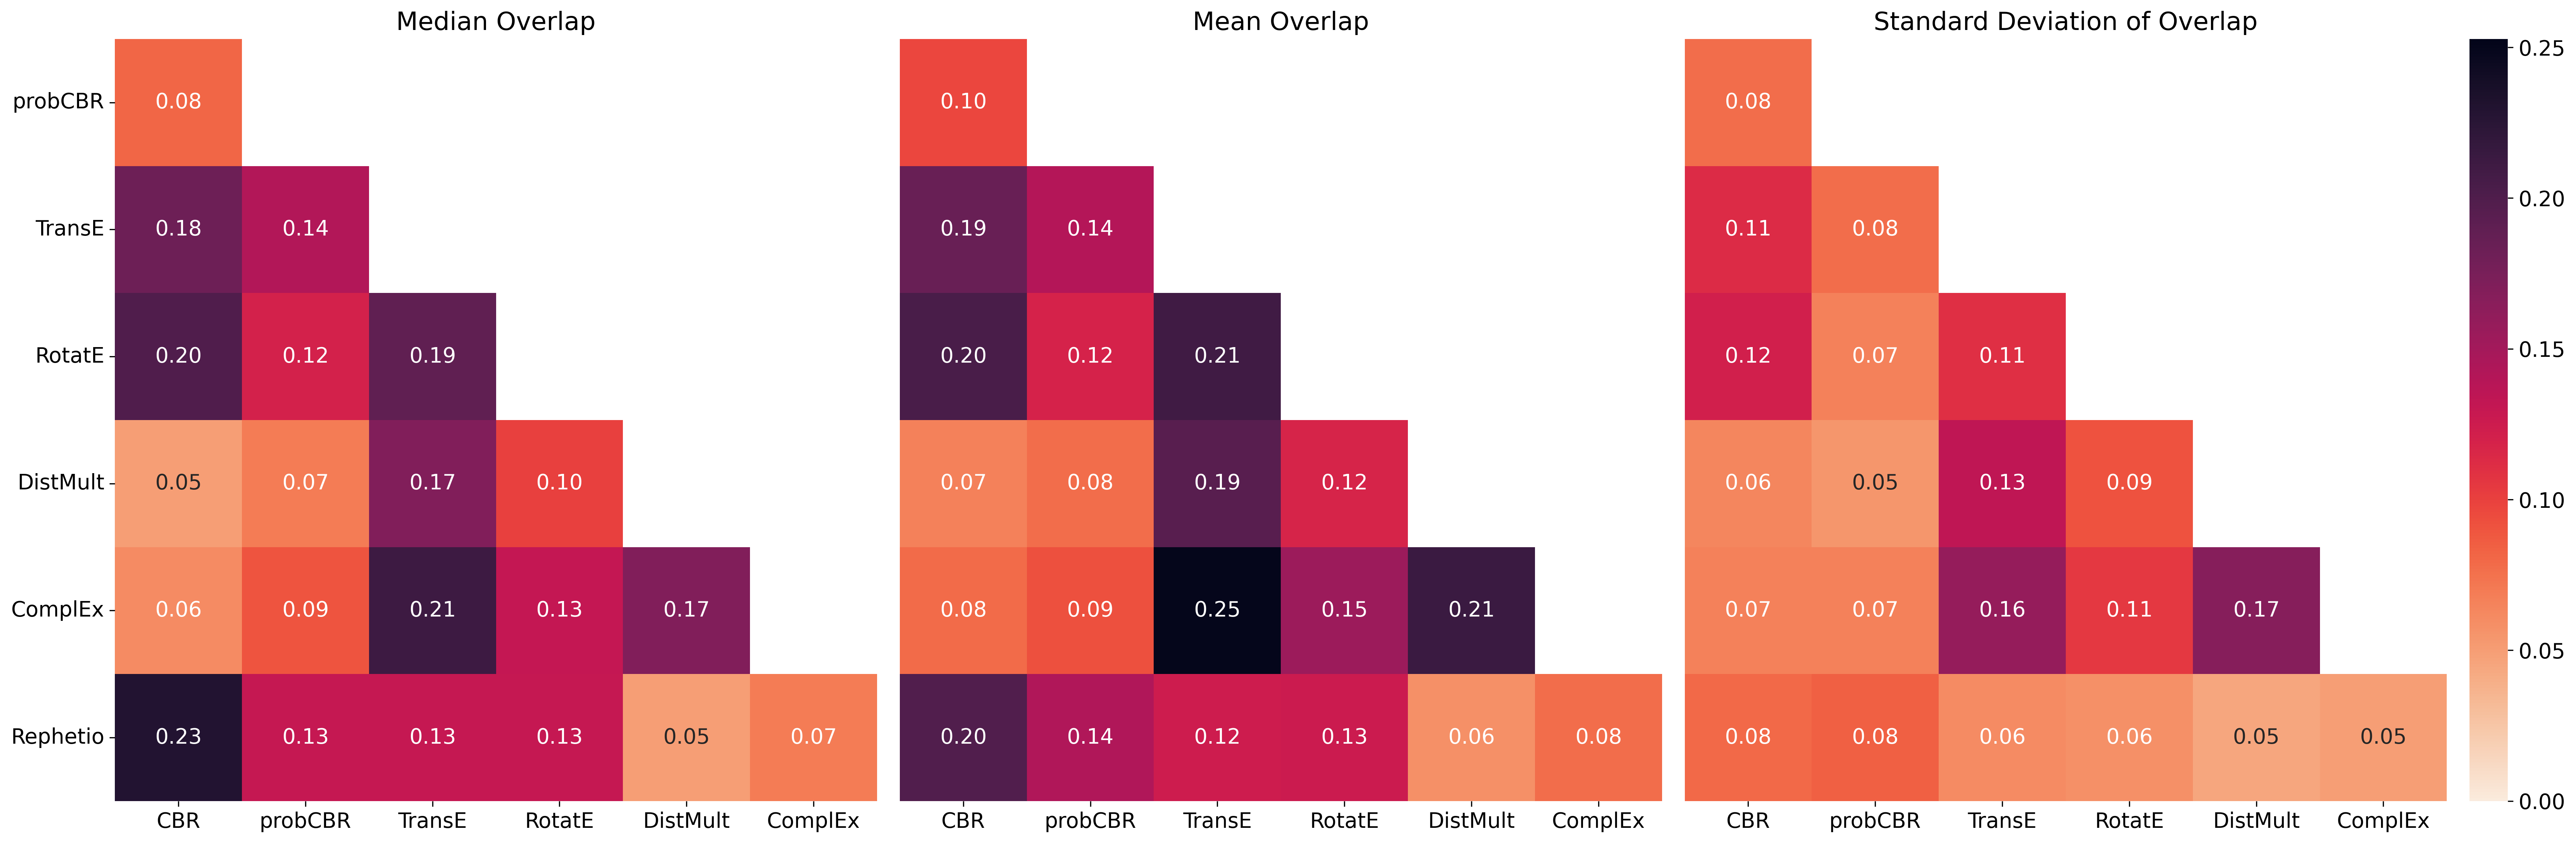

In [132]:
cmap = sns.cm.rocket_r
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    1, 4, gridspec_kw={"width_ratios": [1, 1, 1, 0.05]}
)

# specify min and max on legend
vmin = min(
    mead_hm_df.fillna(0).values.min(),
    mean_hm_df.fillna(0).values.min(),
    std_hm_df.fillna(0).values.min(),
)
vmax = max(
    mead_hm_df.fillna(0).values.max(),
    mean_hm_df.fillna(0).values.max(),
    std_hm_df.fillna(0).values.max(),
)

# median heatmap
mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]

sns.heatmap(
    mead_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax0,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Median Overlap")
ax0.tick_params(axis="y", rotation=0)

# mean heatmap
sns.heatmap(
    mean_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax1,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Mean Overlap")
ax1.set_yticklabels(
    [
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)
ax1.tick_params(left=False)

# std heatmap
sns.heatmap(
    std_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax2,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("Standard Deviation of Overlap")
ax2.set_yticklabels(
    [
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)
ax2.tick_params(left=False)

for ax in fig.get_axes():
    ax.tick_params(axis="x", rotation=0)

# legend as a seperate
ax3 = fig.colorbar(
    ax0.get_children()[0],
    cax=ax3,
    orientation="vertical",
)
ax3.outline.set_visible(False)

# fig.suptitle(
#     "Overlap Frequency between Top 100 Predictions on Test Set",
#     fontweight="bold",
#     fontsize=16,
# )

plt.tight_layout()
#plt.savefig("Heatmap_Overlap_notitle.png", facecolor="white", edgecolor="none")
plt.show()

## Get ranking differences between overlapping results

In [133]:
kge_ls3[5].head(2)

,h,filt_preds,algo
0,CHEBI:135735,"[WD:Q25303605, UMLS:C0221155, DOID:14172, DOID...",ComplEx
1,CHEBI:135738,"[WD:Q25303605, UMLS:C0221155, NCBIGene:1487, D...",ComplEx


In [145]:
def overlap_list(x: list, y: list) -> list:
    """
    Returns a list of the overlap between two lists
    """
    return list(set(x).intersection(set(y)))


def overlap_list_location(x: list, y: list) -> list:
    """
    Takes two lists and returns the location of overlapping objects as a list(tuple)
    """
    unique = list(set(x).intersection(set(y)))

    return [(x.index(i), y.index(i)) for i in unique]


def overlap_diff(
    x: list,
    y: list,
) -> list:
    """
    takes two lists to compare as inputs
    returns the difference in ranks in overlapping objects in the two lists.
    """
    if len(x) > len(y):
        old_x = x
        old_y = y
        x = old_y
        y = old_x

    overlap_diff_ls = list()
    for i, v in enumerate(x):
        #        short_ls = []
        #        for w in v:
        loc_ls = overlap_list_location(v, y[i])
        overlap_diff_ls.append(
            [abs(j[0] - j[1]) for j in loc_ls]
        )  # difference between tuples

    return overlap_diff_ls

In [146]:
# make permutations of previously created dataframes to compare every combination of result lists
kge_ls5 = list()
kge_ls5 += itertools.permutations(kge_ls3, 2)

In [147]:
kge_diff_tup_ls = list()
for h, (i, j) in enumerate(kge_ls5):
    # make sure all nan are removed
    i = i.dropna()
    j = j.dropna()

    # make sure the dataframe sizes have the same elements
    intersection = set(i.h) & set(j.h)

    i = i.query("h in @intersection").sort_values("h", ascending=False)
    j = j.query("h in @intersection").sort_values("h", ascending=False)

    # make sure inputs in overlap_diff are lists, series indexing messes with the function
    kge_diff_tup_ls.append(
        (
            i.algo.iloc[0],
            j.algo.iloc[0],
            overlap_diff(list(i.filt_preds), list(j.filt_preds)),
        )
    )

In [148]:
hm_df2 = pd.DataFrame(kge_diff_tup_ls, columns=["g1", "g2", "vals"])
hm_df2.head()

,g1,g2,vals
0,probCBR,CBR,"[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,..."
1,probCBR,Rephetio,"[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3..."
2,probCBR,TransE,"[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [],..."
3,probCBR,DistMult,"[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5..."
4,probCBR,ComplEx,"[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18..."


In [149]:
# vals2 is vals after removing empty lists
hm_df2["vals2"] = hm_df2["vals"].apply(lambda x: [i for i in x if len(i) > 0])
hm_df2.head()

,g1,g2,vals,vals2
0,probCBR,CBR,"[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,...","[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,..."
1,probCBR,Rephetio,"[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3...","[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3..."
2,probCBR,TransE,"[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [],...","[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [48..."
3,probCBR,DistMult,"[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5...","[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5..."
4,probCBR,ComplEx,"[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18...","[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18..."


In [150]:
# vals3 turns a list of list to a list
hm_df2["vals3"] = hm_df2["vals2"].apply(lambda x: [j for i in x for j in i])
hm_df2.head()

,g1,g2,vals,vals2,vals3
0,probCBR,CBR,"[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,...","[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,...","[20, 44, 26, 56, 14, 28, 2, 37, 22, 19, 11, 17..."
1,probCBR,Rephetio,"[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3...","[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3...","[14, 9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 37, ..."
2,probCBR,TransE,"[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [],...","[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [48...","[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89, 48, 5..."
3,probCBR,DistMult,"[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5...","[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5...","[19, 4, 18, 70, 8, 1, 7, 10, 4, 7, 28, 7, 51, ..."
4,probCBR,ComplEx,"[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18...","[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18...","[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18,..."


In [151]:
# get the median, mean and standard deviation of the differences between each pair of algorithms
hm_df2["median"] = hm_df2.vals3.apply(lambda x: statistics.median(x))
hm_df2["mean"] = hm_df2.vals3.apply(lambda x: float(statistics.mean(x)))
hm_df2["std"] = hm_df2.vals3.apply(lambda x: float(statistics.stdev(x)))
hm_df2.head()

,g1,g2,vals,vals2,vals3,median,mean,std
0,probCBR,CBR,"[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,...","[[20, 44, 26, 56, 14, 28, 2], [37, 22, 19, 11,...","[20, 44, 26, 56, 14, 28, 2, 37, 22, 19, 11, 17...",25.0,30.581307,23.046486
1,probCBR,Rephetio,"[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3...","[[14], [9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 3...","[14, 9, 44, 9, 40, 4, 43, 6, 18, 1, 0, 0, 37, ...",24.0,28.874849,22.136277
2,probCBR,TransE,"[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [],...","[[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89], [48...","[38, 8, 6, 3, 8, 6, 52, 2, 12, 6, 4, 89, 48, 5...",26.0,30.917402,22.899796
3,probCBR,DistMult,"[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5...","[[19, 4, 18, 70, 8, 1, 7, 10, 4, 7], [28, 7, 5...","[19, 4, 18, 70, 8, 1, 7, 10, 4, 7, 28, 7, 51, ...",28.0,32.448239,23.807133
4,probCBR,ComplEx,"[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18...","[[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18...","[68, 3, 3, 3, 4, 15, 33, 42, 3, 2, 43, 13, 18,...",27.0,31.534379,23.160474


In [152]:
# create individual dataframes
hm_df2[["g1", "g2", "median"]].pivot(index="g1", columns="g2")

median                                                
g2          CBR ComplEx DistMult Rephetio RotatE TransE probCBR
g1                                                             
CBR         NaN    28.0     29.0     21.0   26.0   27.0    25.0
ComplEx    28.0     NaN     20.0     28.0   25.0   22.0    27.0
DistMult   29.0    20.0      NaN     33.0   27.0   23.0    28.0
Rephetio   21.0    28.0     33.0      NaN   26.0   29.0    24.0
RotatE     26.0    25.0     27.0     26.0    NaN   25.0    27.0
TransE     27.0    22.0     23.0     29.0   25.0    NaN    26.0
probCBR    25.0    27.0     28.0     24.0   27.0   26.0     NaN

In [153]:
# create individual dataframes
hm_df2_med = hm_df2[["g1", "g2", "median"]].pivot(index="g1", columns="g2")
hm_df2_med = (
    hm_df2_med["median"]
    .reset_index()
    .loc[
        [0, 6, 5, 4, 2, 1, 3],
        ["g1", "CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"],
    ]
)
hm_df2_med.columns.name = None
hm_df2_med.set_index("g1")

,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
g1,,,,,,,
CBR,NaN,25.0,27.0,26.0,29.0,28.0,21.0
probCBR,25.0,NaN,26.0,27.0,28.0,27.0,24.0
TransE,27.0,26.0,NaN,25.0,23.0,22.0,29.0
RotatE,26.0,27.0,25.0,NaN,27.0,25.0,26.0
DistMult,29.0,28.0,23.0,27.0,NaN,20.0,33.0
ComplEx,28.0,27.0,22.0,25.0,20.0,NaN,28.0
Rephetio,21.0,24.0,29.0,26.0,33.0,28.0,NaN


In [154]:
# create individual dataframes
hm_df2_mean = hm_df2[["g1", "g2", "mean"]].pivot(index="g1", columns="g2")
hm_df2_mean = (
    hm_df2_mean["mean"]
    .reset_index()
    .loc[
        [0, 6, 5, 4, 2, 1, 3],
        ["g1", "CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"],
    ]
)
hm_df2_mean.columns.name = None
hm_df2_mean.set_index("g1")

,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
g1,,,,,,,
CBR,NaN,30.581307,31.312966,31.001815,33.745588,32.084851,25.741466
probCBR,30.581307,NaN,30.917402,31.750292,32.448239,31.534379,28.874849
TransE,31.312966,30.917402,NaN,29.459803,28.532883,26.993701,32.833262
RotatE,31.001815,31.750292,29.459803,NaN,31.363656,30.178954,31.324733
DistMult,33.745588,32.448239,28.532883,31.363656,NaN,25.966190,36.168969
ComplEx,32.084851,31.534379,26.993701,30.178954,25.966190,NaN,32.630615
Rephetio,25.741466,28.874849,32.833262,31.324733,36.168969,32.630615,NaN


In [155]:
# create individual dataframes
hm_df2_std = hm_df2[["g1", "g2", "std"]].pivot(index="g1", columns="g2")
hm_df2_std = (
    hm_df2_std["std"]
    .reset_index()
    .loc[
        [0, 6, 5, 4, 2, 1, 3],
        ["g1", "CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"],
    ]
)
hm_df2_std.columns.name = None
hm_df2_std.set_index("g1")

,CBR,probCBR,TransE,RotatE,DistMult,ComplEx,Rephetio
g1,,,,,,,
CBR,NaN,23.046486,22.547688,22.888084,23.809489,23.251263,20.985228
probCBR,23.046486,NaN,22.899796,23.662744,23.807133,23.160474,22.136277
TransE,22.547688,22.899796,NaN,22.884479,22.888119,21.919828,23.780050
RotatE,22.888084,23.662744,22.884479,NaN,23.622217,23.346491,23.539019
DistMult,23.809489,23.807133,22.888119,23.622217,NaN,21.851222,24.528619
ComplEx,23.251263,23.160474,21.919828,23.346491,21.851222,NaN,23.135604
Rephetio,20.985228,22.136277,23.780050,23.539019,24.528619,23.135604,NaN


In [156]:
hm_df2_mean.fillna(0)[
    ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
].values.max()

36.168968692449354

In [157]:
hm_df2_med = hm_df2_med.set_index("g1")
hm_df2_mean = hm_df2_mean.set_index("g1")
hm_df2_std = hm_df2_std.set_index("g1")

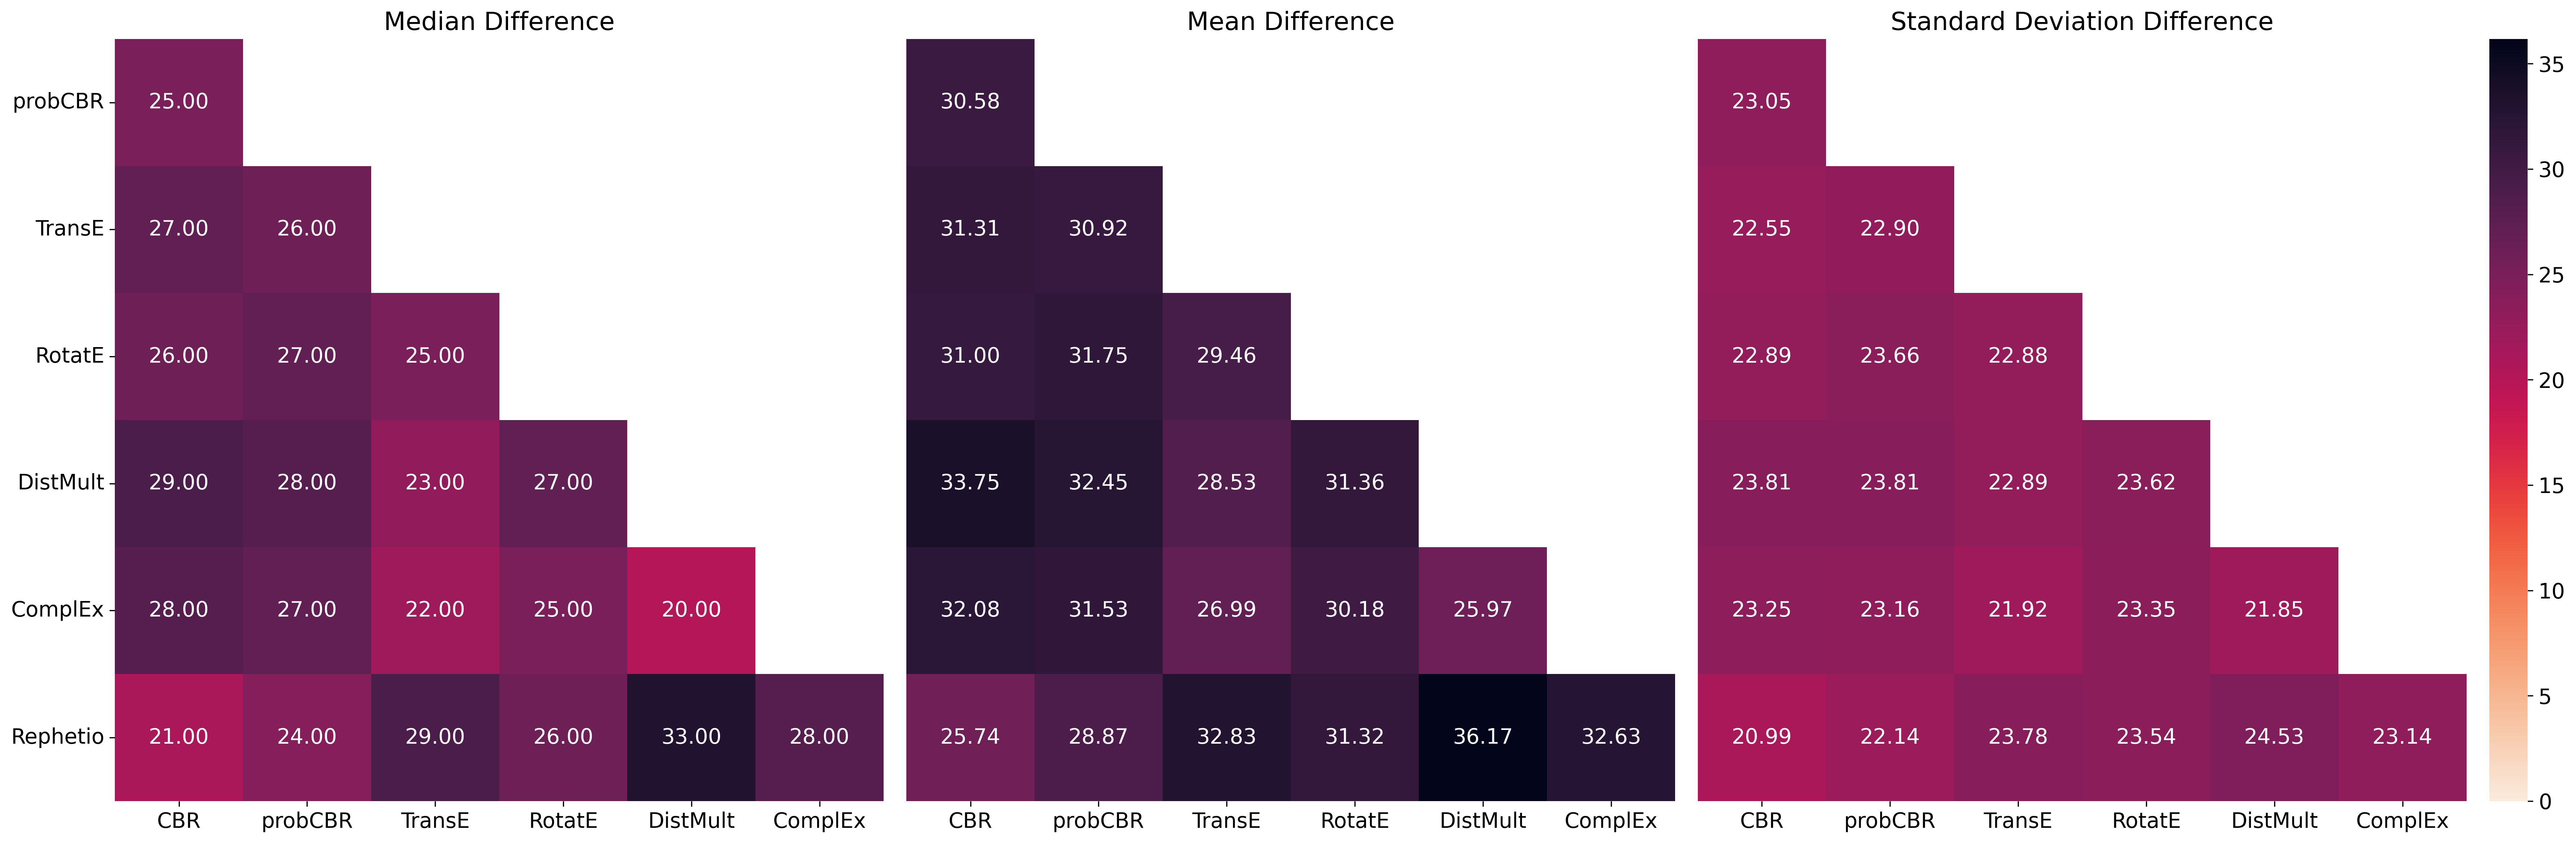

In [158]:
cmap = sns.cm.rocket_r
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    1, 4, gridspec_kw={"width_ratios": [1, 1, 1, 0.05]}
)

# specify min and max on legend
vmin = min(
    hm_df2_med.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.min(),
    hm_df2_mean.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.min(),
    hm_df2_std.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.min(),
)
vmax = max(
    hm_df2_med.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.max(),
    hm_df2_mean.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.max(),
    hm_df2_std.fillna(0)[
        ["CBR", "probCBR", "TransE", "RotatE", "DistMult", "ComplEx", "Rephetio"]
    ].values.max(),
)

# median heatmap
sns.heatmap(
    hm_df2_med.iloc[1:, :-1],
    mask=mask,
    ax=ax0,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Median Difference")
ax0.tick_params(axis="y", rotation=0)

# mean heatmap
sns.heatmap(
    hm_df2_mean.iloc[1:, :-1],
    mask=mask,
    ax=ax1,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Mean Difference")
ax1.set_yticklabels(
    [
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)
ax1.tick_params(left=False)

# std heatmap
sns.heatmap(
    hm_df2_std.iloc[1:, :-1],
    mask=mask,
    ax=ax2,
    cbar=False,
    vmin=vmin,
    vmax=vmax,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_title("Standard Deviation Difference")
ax2.set_yticklabels(
    [
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)
ax2.tick_params(left=False)

for ax in fig.get_axes():
    ax.tick_params(axis="x", rotation=0)

# legend as a seperate
ax3 = fig.colorbar(
    ax0.get_children()[0],
    cax=ax3,
    orientation="vertical",
)
ax3.outline.set_visible(False)


# fig.suptitle(
#     "Prediction Ranking Difference between Top 100 Predictions on Test Set",
#     fontweight="bold",
#     fontsize=16,
# )
plt.tight_layout()
#plt.savefig("Heatmap_Difference_notitle.png", facecolor="white", edgecolor="none")
plt.show()

/tmp/ipykernel_3182089/1241896686.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]


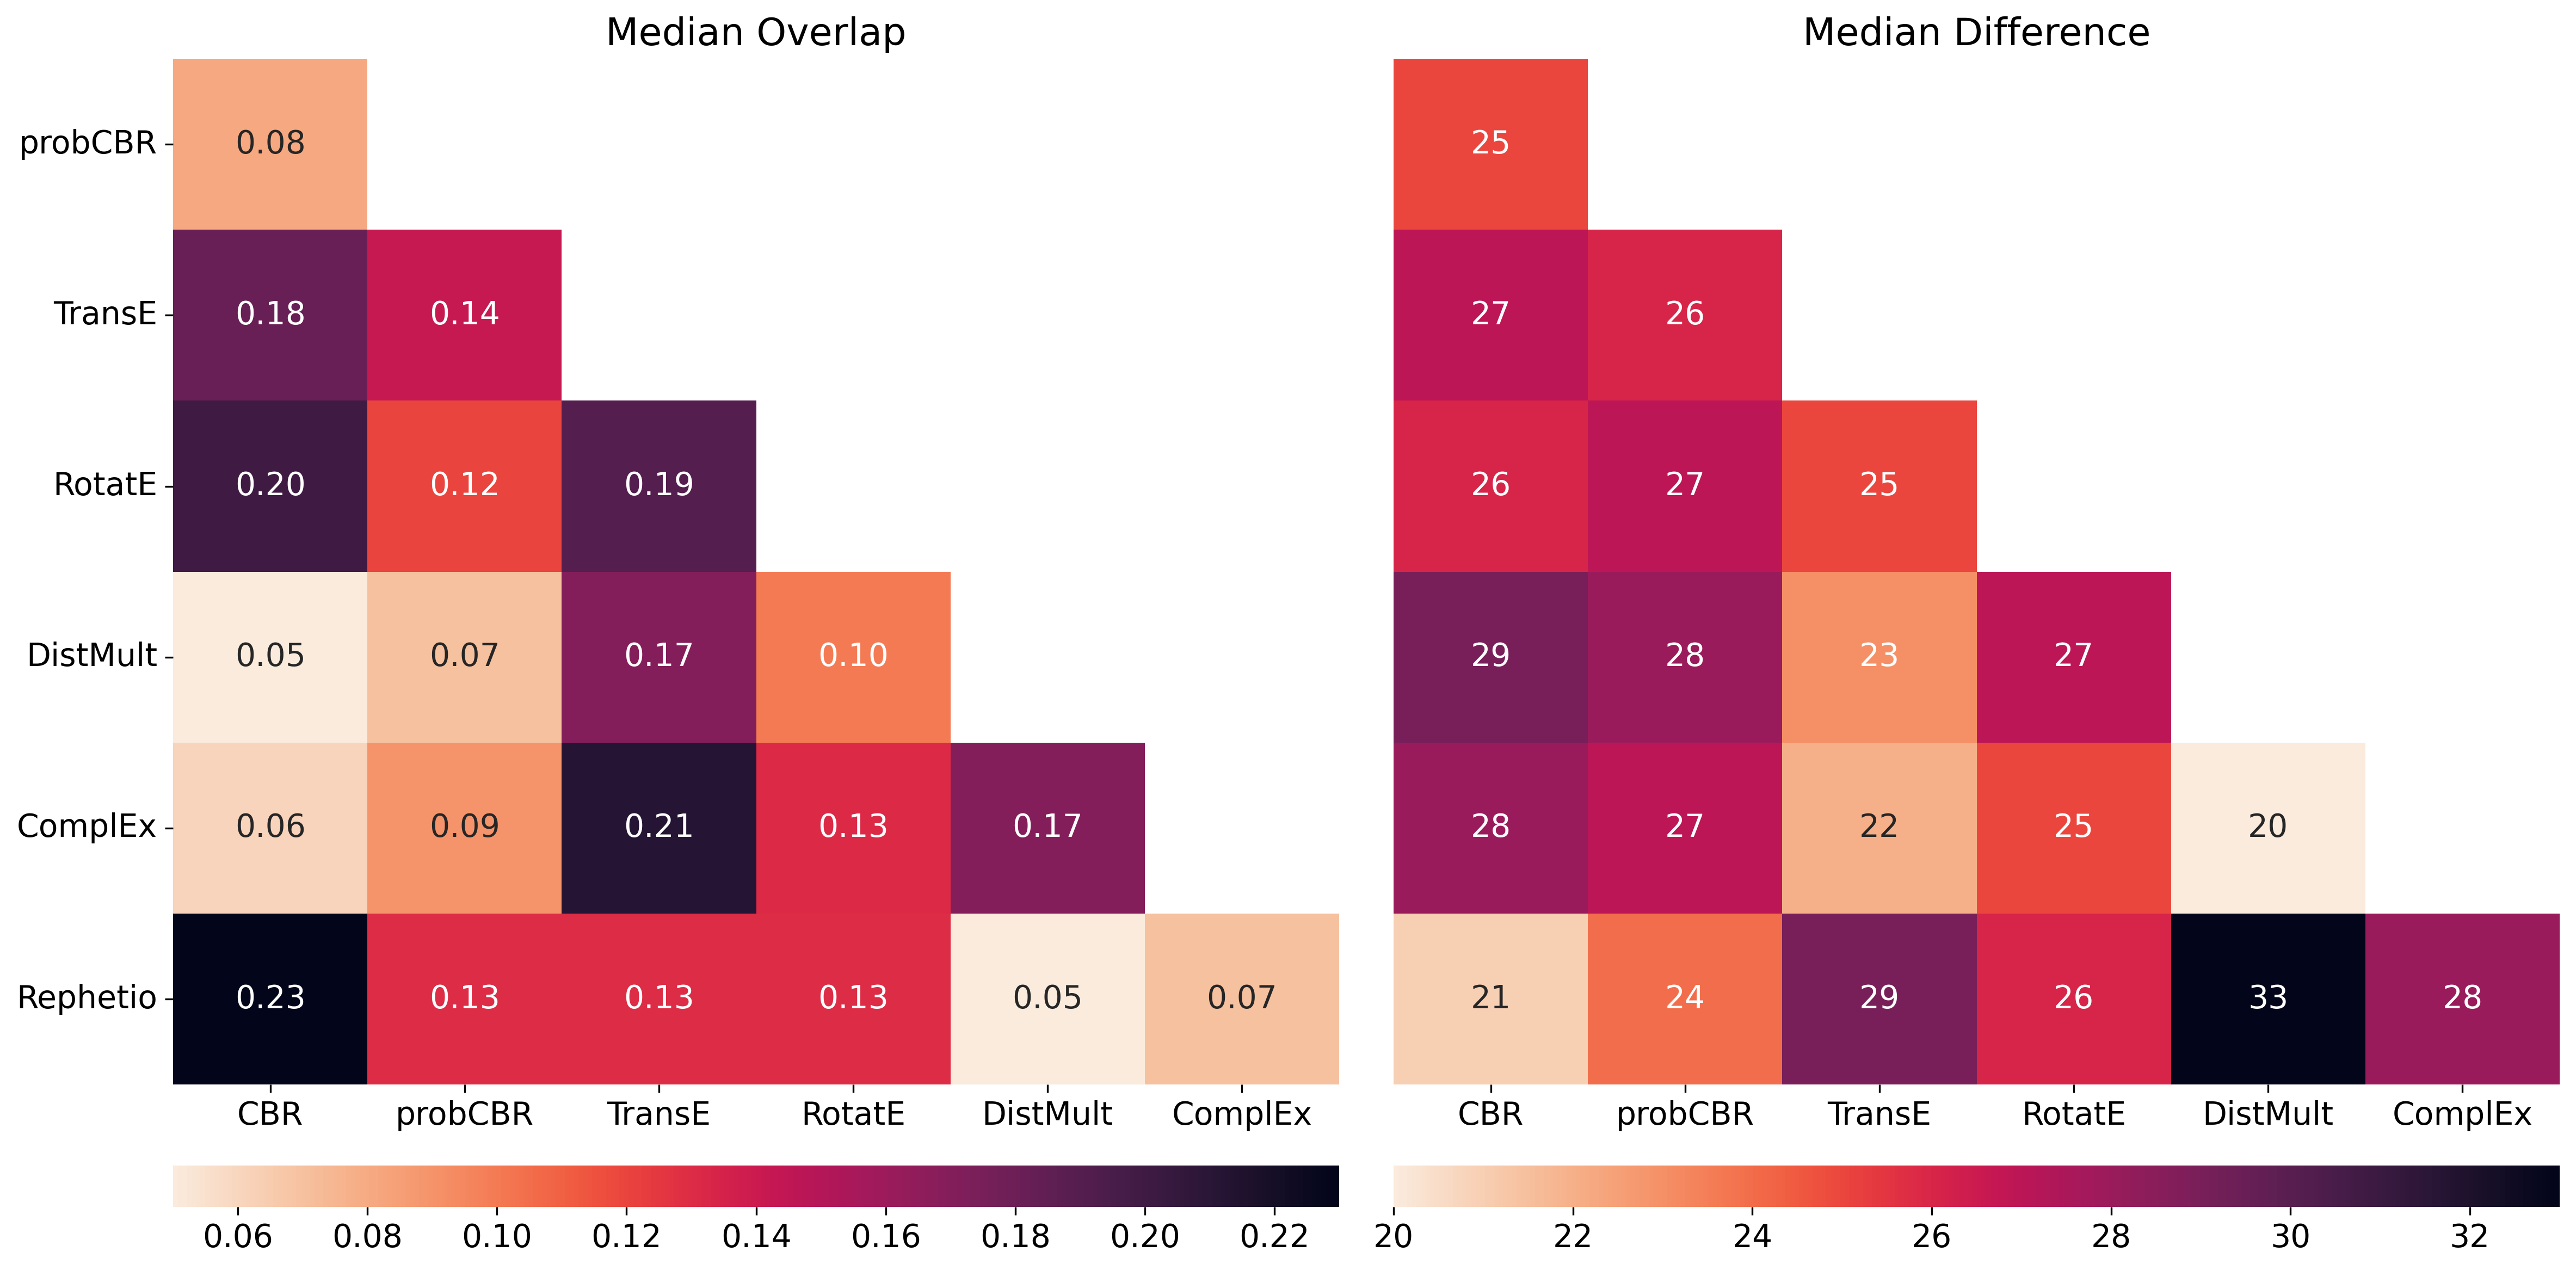

In [159]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    nrows=2,
    ncols=2,
    gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1, 0.04]},
    figsize=(16, 8),
)

# median heatmap
mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]

# sns.heatmap(mead_hm_df.iloc[1:,:-1],mask = mask, ax=ax0, cbar=False, vmin=vmin, vmax=vmax, annot=True, fmt=".2f")
sns.heatmap(
    mead_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax0,
    cbar=False,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)  # square = True)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Median Overlap")
ax0.tick_params(axis="y", rotation=0)


# median heatmap
sns.heatmap(
    hm_df2_med.iloc[1:, :-1],
    mask=mask,
    ax=ax1,
    cbar=False,
    annot=True,
    fmt=".0f",
    cmap=cmap,
)  # square = True)
ax1.set_ylabel("")
ax1.set_xlabel("")
ax1.set_title("Median Difference")
ax1.tick_params(axis="y", rotation=0)
ax1.set_yticklabels(
    [
        "",
        "",
        "",
        "",
        "",
        "",
    ]
)
ax1.tick_params(left=False)

# force ticklabels to be horizontal
for ax in fig.get_axes():
    ax.tick_params(axis="x", rotation=0)

# legend as a seperate
ax2 = fig.colorbar(
    ax0.get_children()[0],
    cax=ax2,
    orientation="horizontal",
)

ax2.outline.set_visible(False)

# legend as a seperate
ax3 = fig.colorbar(
    ax1.get_children()[0],
    cax=ax3,
    orientation="horizontal",
)
ax3.outline.set_visible(False)


plt.tight_layout()
plt.savefig("Heatmap_Overlap_notitle.png", facecolor="white", edgecolor="none")
plt.show()

/tmp/ipykernel_3182089/596407775.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]


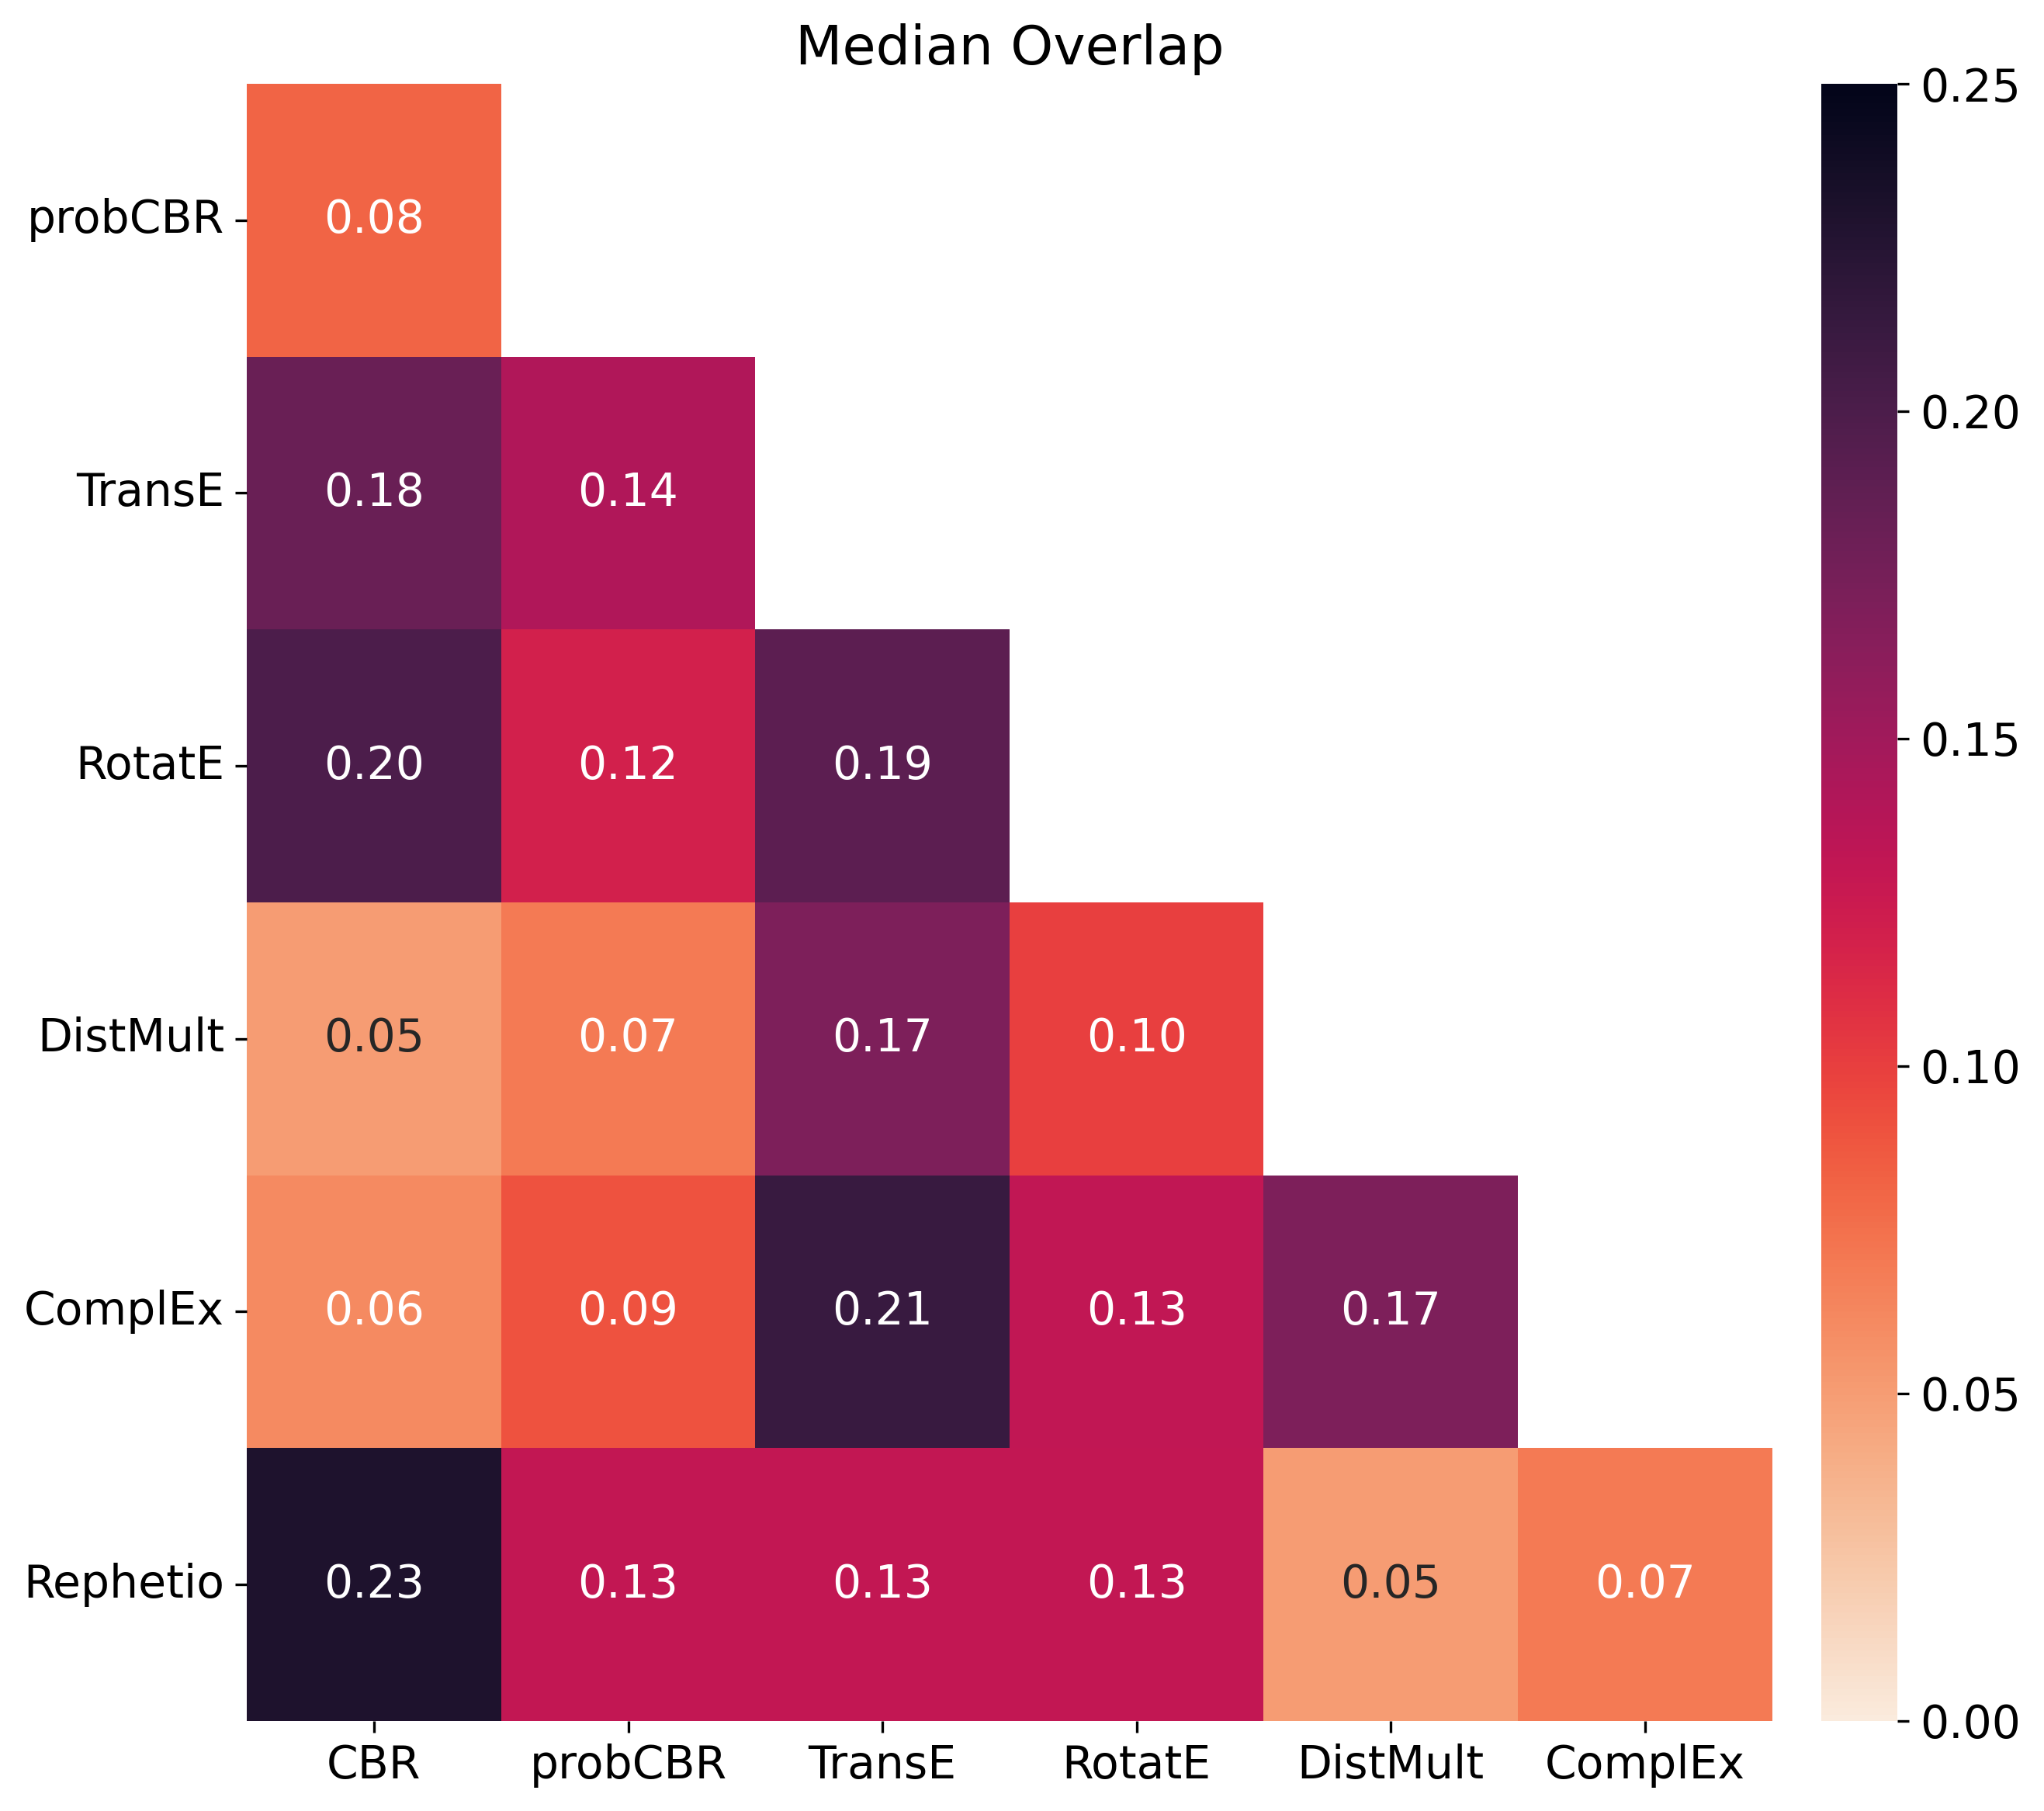

In [187]:
cmap = sns.cm.rocket_r
fig, (ax0, ax1) = plt.subplots(
    1, 2, gridspec_kw={"width_ratios": [1, 0.05]},
    figsize=(9, 8),
)

# median heatmap
mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]

sns.heatmap(
    mead_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax0,
    cbar=False,
    vmax=0.25,
    vmin=0,
    annot=True,
    fmt=".2f",
    cmap=cmap,
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Median Overlap")
ax0.tick_params(axis="y", rotation=0)

for ax in fig.get_axes():
    ax.tick_params(axis="x", rotation=0)

# legend as a seperate
ax1 = fig.colorbar(
    ax0.get_children()[0],
    cax=ax1,
    orientation="vertical",
)
ax1.outline.set_visible(False)

plt.tight_layout()
plt.savefig("Median_Heatmap_Overlap.png", facecolor="white", edgecolor="none")
plt.show()

/tmp/ipykernel_3182089/2239174305.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]


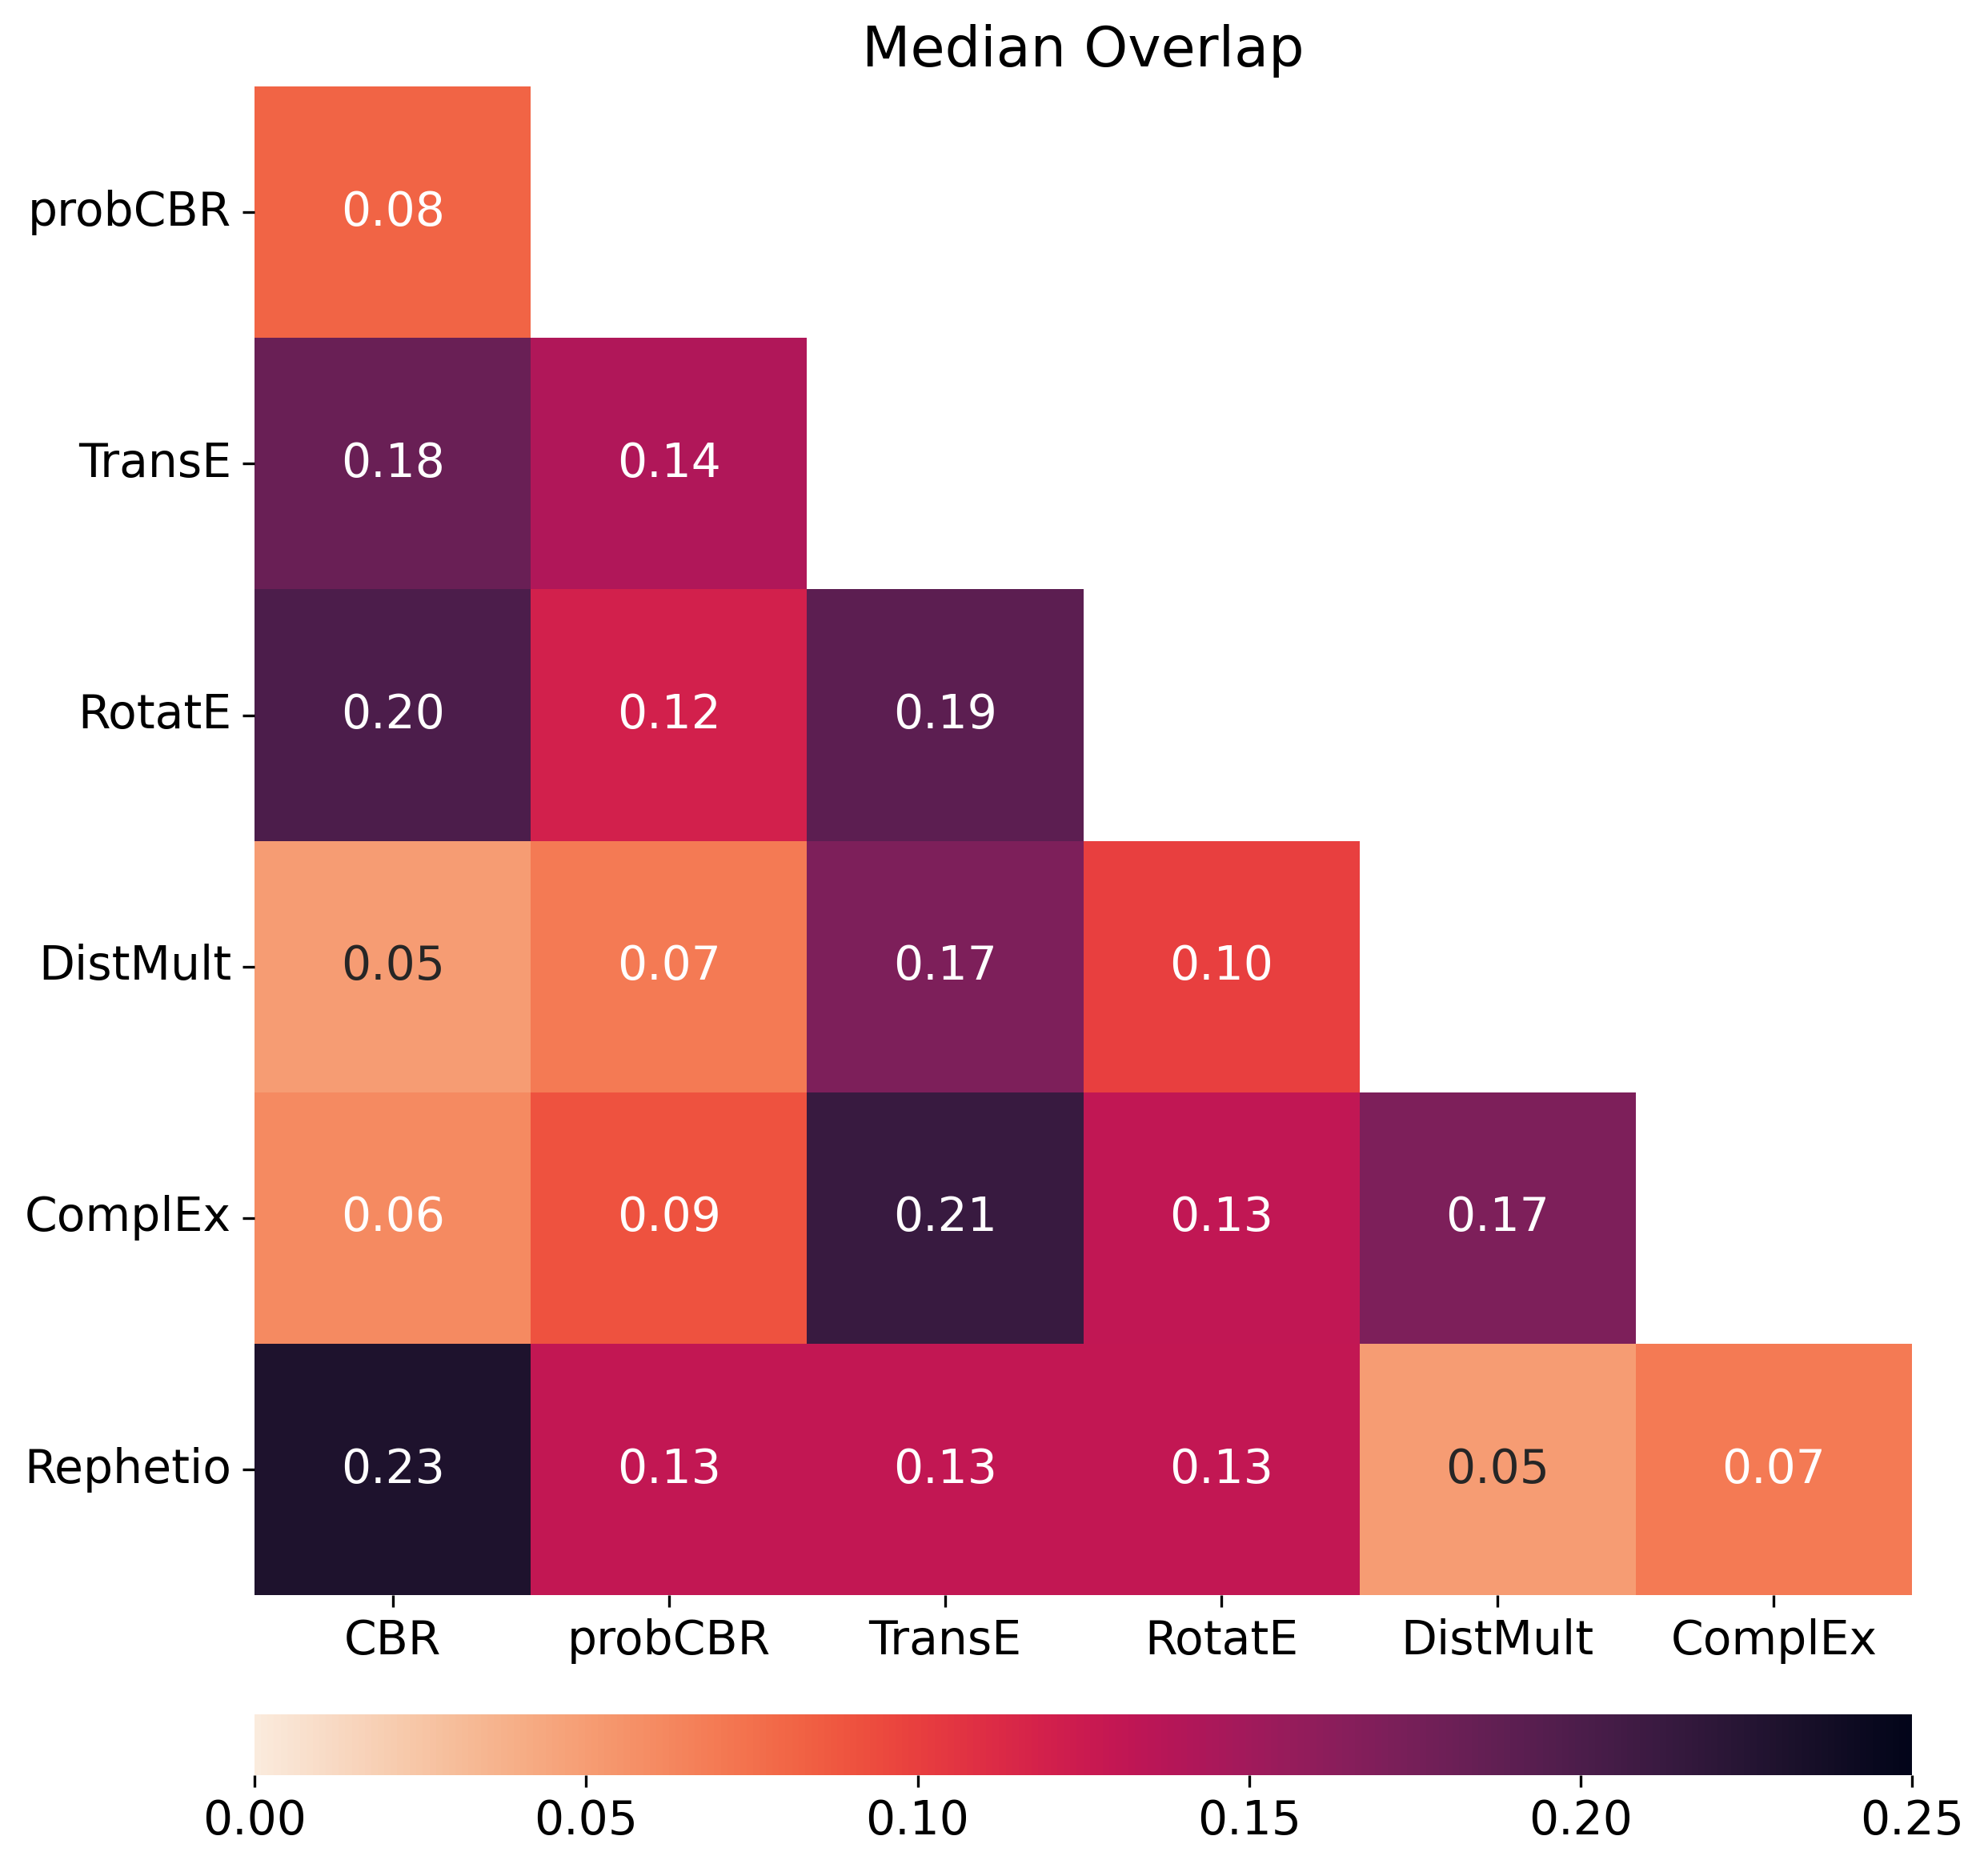

In [198]:
cmap = sns.cm.rocket_r

fig, (ax0, ax1) = plt.subplots(
    nrows=2,
    ncols=1,
    gridspec_kw={"height_ratios": [1, 0.04]},
    figsize=(8.5, 8),
)

# median heatmap
mask = np.triu(np.ones_like(mead_hm_df, dtype=np.bool))[1:, :-1]

sns.heatmap(
    mead_hm_df.iloc[1:, :-1],
    mask=mask,
    ax=ax0,
    cbar=False,
    vmax=0.25,
    vmin=0,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    #square= True
)
ax0.set_ylabel("")
ax0.set_xlabel("")
ax0.set_title("Median Overlap")
ax0.tick_params(axis="y", rotation=0)

for ax in fig.get_axes():
    ax.tick_params(axis="x", rotation=0)

# legend as a seperate
ax1 = fig.colorbar(
    ax0.get_children()[0],
    cax=ax1,
    orientation="horizontal",
)
ax1.outline.set_visible(False)

plt.tight_layout()
plt.savefig("Median_Heatmap_Overlap_bot.png", facecolor="white", edgecolor="none")
plt.show()

In [180]:
ax0.get_children()

## Get an overlapping list of hits.
* before and after icd9/rxnorm filtration

### Get the highest overlapping objects between all algorithms
* Unfortunately, we can't get an overlap for all algorithms.

In [160]:
kge_ls3[6].filt_preds.apply(lambda x: len(x)).describe()

count    387.000000
mean      99.943152
std        0.231851
min       99.000000
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: filt_preds, dtype: float64

In [161]:
algo_ls = ["TransE", "RotatE", "CBR", "probCBR", "DistMult", "ComplEx", "Rephetio"]
cat_df = pd.concat(kge_ls3).groupby("h").agg(lambda x: list(x))
cat_df.head(2)

,filt_preds,algo
h,,
CHEBI:135735,"[[DOID:6432, DOID:6000, DOID:10591, DOID:10825...","[probCBR, CBR, Rephetio, TransE, DistMult, Com..."
CHEBI:135738,"[[DOID:446, DOID:10591, DOID:10824, DOID:11130...","[probCBR, CBR, Rephetio, TransE, DistMult, Com..."


In [162]:
cat_df.shape

(387, 2)

In [163]:
# convert algo to set because order isn't important
cat_df["algo"] = cat_df["algo"].apply(lambda x: set(x))
# Filter for results that have all the algorithms.
cat_df2 = cat_df[cat_df["algo"] == set(algo_ls)]

cat_df.head(2)

,filt_preds,algo
h,,
CHEBI:135735,"[[DOID:6432, DOID:6000, DOID:10591, DOID:10825...","{ComplEx, TransE, Rephetio, CBR, DistMult, pro..."
CHEBI:135738,"[[DOID:446, DOID:10591, DOID:10824, DOID:11130...","{ComplEx, TransE, Rephetio, CBR, DistMult, pro..."


In [164]:
cat_df2.shape

(322, 2)

In [165]:
cat_df2.algo.apply(lambda x: len(x)).describe()

count    322.0
mean       7.0
std        0.0
min        7.0
25%        7.0
50%        7.0
75%        7.0
max        7.0
Name: algo, dtype: float64

In [166]:
# function for determining the unique set for all algos per indication.
def overlap_counter(x: list) -> list:
    """
    takes a list of list and returns a list of intersections between all the lists supplied
    """
    # get a item count of all
    a_dict = dict()
    for k in [j for i in x for j in i]:
        if k not in a_dict.keys():
            a_dict[k] = 0
        else:
            a_dict[k] += 1
    return a_dict


# function for getting the n_overlapping objects in a list
def overlap_size(x: list, y: int = 7) -> list:
    overlap_dict = overlap_counter(x)

    # if the dictionary object has 'y' overlaps return the object into a list
    return [i[0] for i in overlap_dict.items() if i[1] >= y]


# function for overlap
def overlap_percentage(x: list, y: int = 7) -> float:
    """
    takes a list of list and returns the length of unique items divided by the smallest list
    - y considers the minimum number of overlaps
    """
    num_overlaps = len(overlap_size(x, y))
    smallest_list = min([len(i) for i in x])
    return num_overlaps / smallest_list

In [167]:
# all algo overlap?
cat_df2.filt_preds.apply(lambda x: len(overlap_size(x, 7))).describe()

count    322.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: filt_preds, dtype: float64

In [168]:
# at least 6 algo overlaps?
cat_df2.filt_preds.apply(lambda x: len(overlap_size(x, 6))).describe()

count    322.000000
mean       0.217391
std        0.623483
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        5.000000
Name: filt_preds, dtype: float64

In [169]:
# at least 5 algo overlaps?
cat_df2.filt_preds.apply(lambda x: len(overlap_size(x, 5))).describe()

count    322.000000
mean       1.276398
std        1.676668
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: filt_preds, dtype: float64